In [1]:
import os
import librosa
import numpy as np
import pandas as pd

# Funcție pentru extragerea spectrelor Mel dintr-un fișier audio
def extract_mel_spectrogram(file_path, n_mels=128, fmax=8000):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Rata de eșantionare 22.050 Hz
        mel_spectrogram = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=n_mels, fmax=fmax
        )
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        return log_mel_spectrogram
    except Exception as e:
        print(f"Eroare la procesarea fișierului {file_path}: {e}")
        return None

# Creăm datasetul din fișierele organizate pe genuri
def create_dataset_from_audio_files(base_dir, n_mels=128, fmax=8000):
    data = []
    labels = []
    for genre in os.listdir(base_dir):
        genre_path = os.path.join(base_dir, genre)
        if os.path.isdir(genre_path):  # Verificăm dacă este un director
            for file in os.listdir(genre_path):
                file_path = os.path.join(genre_path, file)
                if file_path.endswith(".wav"):  # Procesăm doar fișiere WAV
                    mel_spectrogram = extract_mel_spectrogram(file_path, n_mels, fmax)
                    if mel_spectrogram is not None:
                        # Redimensionăm la dimensiune fixă (128x128)
                        mel_spectrogram_resized = librosa.util.fix_length(mel_spectrogram, size=128, axis=1)
                        data.append(mel_spectrogram_resized)
                        labels.append(genre)
    return np.array(data), np.array(labels)

# Calea către directoarele de genuri
AUDIO_DIR = "Data/genres_original"  # Înlocuiește cu calea corectă

# Creăm datasetul
print("Procesăm fișierele WAV...")
X, y = create_dataset_from_audio_files(AUDIO_DIR)

# Salvăm datele preprocesate
np.save("X_mel_spectrogram.npy", X)  # Spectrele Mel
np.save("y_labels.npy", y)           # Etichetele corespunzătoare
print("Preprocesarea a fost finalizată!")

# Verificăm dimensiunile datelor
print(f"Spectre procesate: {X.shape}")
print(f"Etichete: {len(y)}")


Procesăm fișierele WAV...


/var/folders/jm/sspkp1jd65l54k1fw6h0hq5w0000gn/T/ipykernel_47713/1333022725.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)  # Rata de eșantionare 22.050 Hz
/Users/mihaiosan/PycharmProjects/ProiectIA/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Eroare la procesarea fișierului Data/genres_original/jazz/jazz.00054.wav: 
Preprocesarea a fost finalizată!
Spectre procesate: (999, 128, 128)
Etichete: 999


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import librosa

# Funcție pentru extragerea spectrelor Mel
def extract_mel_spectrogram(y, sr, n_mels=128, fmax=8000):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=n_mels, fmax=fmax
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

# Funcție pentru segmentarea audio
def segment_audio(file_path, segment_length=3, n_mels=128, fmax=8000):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        segment_samples = segment_length * sr
        segments = []

        for start in range(0, len(y), segment_samples):
            end = start + segment_samples
            if end <= len(y):
                segment = y[start:end]
                mel_spectrogram = extract_mel_spectrogram(segment, sr, n_mels, fmax)
                mel_spectrogram_resized = librosa.util.fix_length(mel_spectrogram, size=128, axis=1)
                segments.append(mel_spectrogram_resized)
        return segments
    except Exception as e:
        print(f"Eroare la procesarea fișierului {file_path}: {e}")
        return []

# Funcție pentru crearea datasetului
def create_segmented_dataset(base_dir, segment_length=3, n_mels=128, fmax=8000):
    data = []
    labels = []
    for genre in os.listdir(base_dir):
        genre_path = os.path.join(base_dir, genre)
        if os.path.isdir(genre_path):
            for file in os.listdir(genre_path):
                file_path = os.path.join(genre_path, file)
                if file_path.endswith(".wav"):
                    segments = segment_audio(file_path, segment_length, n_mels, fmax)
                    data.extend(segments)
                    labels.extend([genre] * len(segments))
    return np.array(data), np.array(labels)

# Calea către directoarele de genuri
BASE_DIR = "Data/genres_original"



Procesăm fișierele WAV...


/var/folders/jm/sspkp1jd65l54k1fw6h0hq5w0000gn/T/ipykernel_47713/2863278525.py:23: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)
/Users/mihaiosan/PycharmProjects/ProiectIA/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Eroare la procesarea fișierului Data/genres_original/jazz/jazz.00054.wav: 
Afișăm spectrograme din genuri diferite...


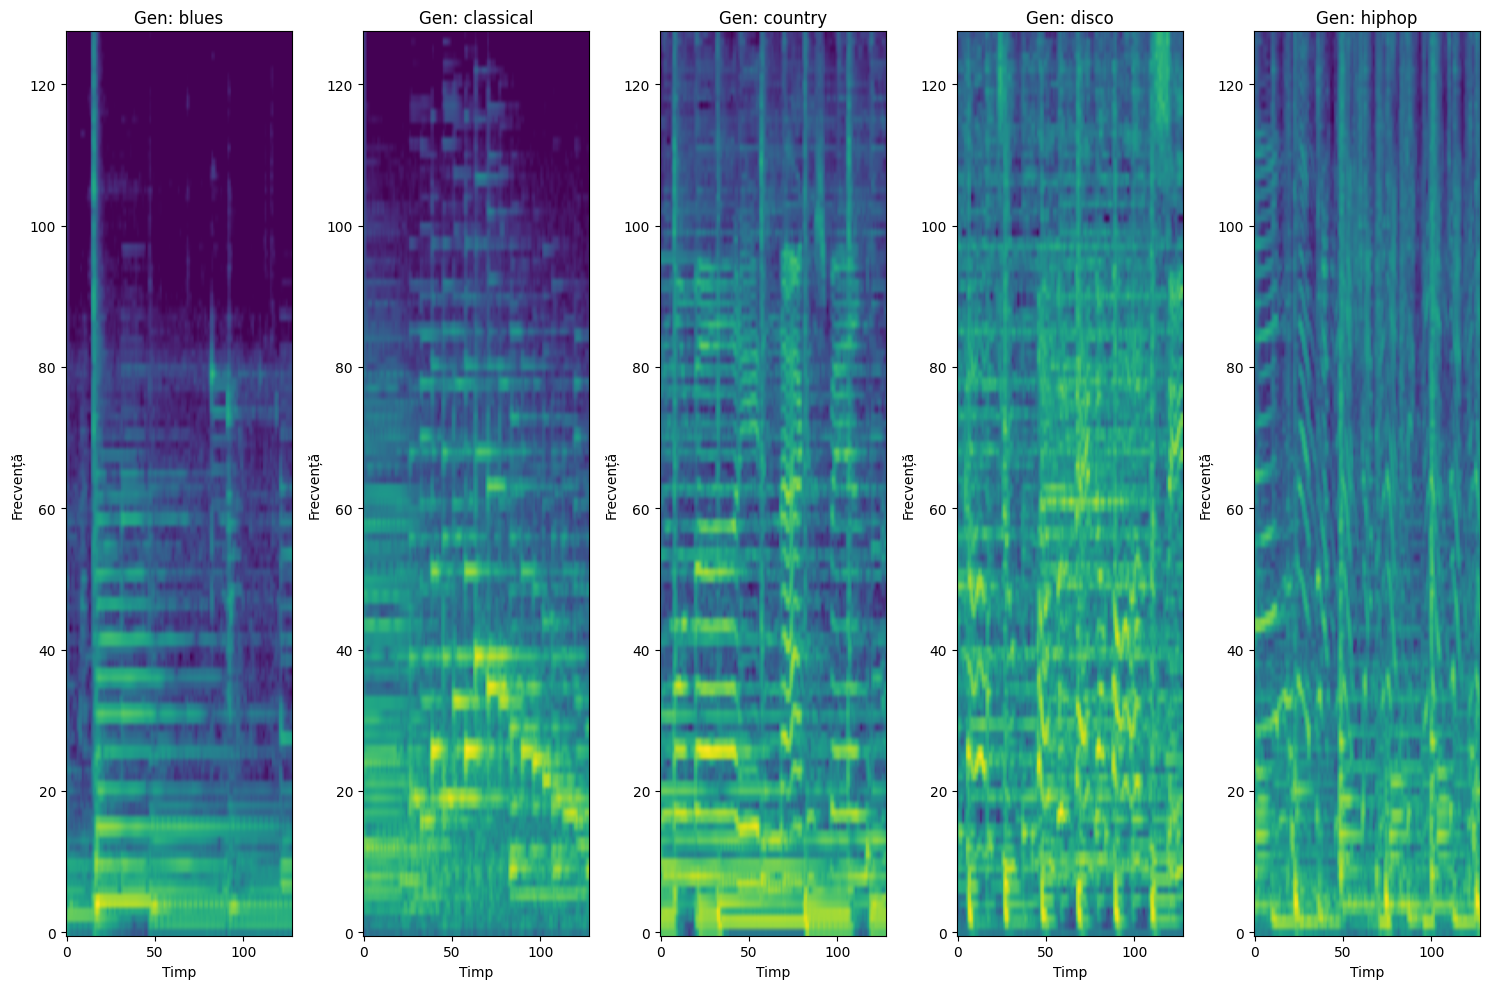

In [3]:
import matplotlib.pyplot as plt

# Funcție pentru afișarea spectrogramelor Mel din genuri diferite
def display_mel_spectrograms_by_genre(X, y, encoder, num_samples=5):
    unique_genres = np.unique(y)  # Genuri unice
    plt.figure(figsize=(15, 10))
    samples_displayed = 0

    for genre in unique_genres:
        if samples_displayed >= num_samples:
            break
        indices = [i for i, label in enumerate(y) if label == genre]
        if indices:
            plt.subplot(1, num_samples, samples_displayed + 1)
            plt.imshow(X[indices[0]].squeeze(), aspect='auto', origin='lower', cmap='viridis')
            plt.title(f"Gen: {encoder.inverse_transform([genre])[0]}")
            plt.xlabel("Timp")
            plt.ylabel("Frecvență")
            samples_displayed += 1

    plt.tight_layout()
    plt.show()

# Procesăm fișierele
print("Procesăm fișierele WAV...")
X, y = create_segmented_dataset(BASE_DIR, segment_length=3)

# Redimensionăm pentru CNN
X = X[..., np.newaxis]

# Encodăm etichetele
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Afișăm spectrograme din genuri diferite
print("Afișăm spectrograme din genuri diferite...")
display_mel_spectrograms_by_genre(X, y_encoded, encoder, num_samples=5)


In [4]:
# Encodăm etichetele
y_categorical = tf.keras.utils.to_categorical(y_encoded)

# Împărțim datele
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [5]:
# Definim modelul CNN
model = Sequential([
    Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss pe setul de testare: {test_loss}")
print(f"Acuratețe pe setul de testare: {test_accuracy}")

/Users/mihaiosan/PycharmProjects/ProiectIA/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 256)  │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 27, 27, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,170 (1.69 MB)

 Trainable params: 443,018 (1.69 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.3424 - loss: 1.8903 - val_accuracy: 0.3355 - val_loss: 2.0393
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.5509 - loss: 1.3151 - val_accuracy: 0.5218 - val_loss: 1.4085
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.6540 - loss: 1.0239 - val_accuracy: 0.1723 - val_loss: 4.2479
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.7121 - loss: 0.8561 - val_accuracy: 0.4427 - val_loss: 1.6366
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.7364 - loss: 0.7764 - val_accuracy: 0.4306 - val_loss: 2.5028
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.7829 - loss: 0.6330 - val_accuracy: 0.3220 - val_loss: 3.7563
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.7990 - loss: 0.5883 - val_accuracy: 0.6154 - val_loss: 1.2605
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.8311 - loss: 0.4875 - val_accu

In [6]:
# Dictionar pentru stocarea acurateței
accuracies = {}
accuracies['CNN'] = test_accuracy

In [7]:
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt

# Transformăm spectrogramele Mel în vectori
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

y_train_numeric = np.argmax(y_train, axis=1)
y_test_numeric = np.argmax(y_test, axis=1)


# ----- XGBoost -----
print("Antrenăm modelul XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric="logloss"
)
xgb_model.fit(X_train_flat, y_train_numeric)
y_pred_xgb = xgb_model.predict(X_test_flat)
test_accuracy_xgb = accuracy_score(y_test_numeric, y_pred_xgb)
accuracies['XGBoost'] = test_accuracy_xgb
print(f"Acuratețea XGBoost: {test_accuracy_xgb:.4f}")
print(classification_report(y_test_numeric, y_pred_xgb))

# ----- LightGBM -----
print("Antrenăm modelul LightGBM...")
train_data_lgb = lgb.Dataset(X_train_flat, label=y_train_numeric)
test_data_lgb = lgb.Dataset(X_test_flat, label=y_test_numeric, reference=train_data_lgb)
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_numeric)),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42
}
lgb_model = lgb.train(params, train_data_lgb, num_boost_round=100, valid_sets=[test_data_lgb], callbacks=[lgb.early_stopping(stopping_rounds=10)])
y_pred_lgb = np.argmax(lgb_model.predict(X_test_flat), axis=1)
test_accuracy_lgb = accuracy_score(y_test_numeric, y_pred_lgb)
accuracies['LightGBM'] = test_accuracy_lgb
print(f"Acuratețea LightGBM: {test_accuracy_lgb:.4f}")
print(classification_report(y_test_numeric, y_pred_lgb))

# ----- CatBoost -----
print("Antrenăm modelul CatBoost...")
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=False
)
catboost_model.fit(X_train_flat, y_train_numeric)
y_pred_catboost = catboost_model.predict(X_test_flat)
test_accuracy_catboost = accuracy_score(y_test_numeric, y_pred_catboost)
accuracies['CatBoost'] = test_accuracy_catboost
print(f"Acuratețea CatBoost: {test_accuracy_catboost:.4f}")
print(classification_report(y_test_numeric, y_pred_catboost))


Antrenăm modelul XGBoost...
Acuratețea XGBoost: 0.6219
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       192
           1       0.83      0.87      0.85       194
           2       0.57      0.59      0.58       197
           3       0.53      0.59      0.56       189
           4       0.49      0.57      0.53       197
           5       0.58      0.65      0.61       173
           6       0.76      0.77      0.77       204
           7       0.62      0.56      0.59       208
           8       0.65      0.48      0.55       237
           9       0.51      0.53      0.52       206

    accuracy                           0.62      1997
   macro avg       0.63      0.63      0.62      1997
weighted avg       0.63      0.62      0.62      1997

Antrenăm modelul LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.363376 seconds.
You can set `force_col_wise=true` to remove the overh

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# ----- Random Forest -----
print("Antrenăm modelul Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_numeric)
y_pred_rf = rf_model.predict(X_test_flat)
test_accuracy_rf = accuracy_score(y_test_numeric, y_pred_rf)
accuracies['Random Forest'] = test_accuracy_rf
print(f"Acuratețea Random Forest: {test_accuracy_rf:.4f}")
print(classification_report(y_test_numeric, y_pred_rf))

# ----- Support Vector Machine (SVM) -----
print("Antrenăm modelul SVM...")
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_flat, y_train_numeric)
y_pred_svm = svm_model.predict(X_test_flat)
test_accuracy_svm = accuracy_score(y_test_numeric, y_pred_svm)
accuracies['SVM'] = test_accuracy_svm
print(f"Acuratețea SVM: {test_accuracy_svm:.4f}")
print(classification_report(y_test_numeric, y_pred_svm))

# ----- Logistic Regression -----
print("Antrenăm modelul Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_flat, y_train_numeric)
y_pred_lr = lr_model.predict(X_test_flat)
test_accuracy_lr = accuracy_score(y_test_numeric, y_pred_lr)
accuracies['Logistic Regression'] = test_accuracy_lr
print(f"Acuratețea Logistic Regression: {test_accuracy_lr:.4f}")
print(classification_report(y_test_numeric, y_pred_lr))




Antrenăm modelul Random Forest...
Acuratețea Random Forest: 0.5173
              precision    recall  f1-score   support

           0       0.66      0.46      0.55       192
           1       0.75      0.84      0.80       194
           2       0.42      0.45      0.43       197
           3       0.33      0.48      0.39       189
           4       0.40      0.48      0.44       197
           5       0.69      0.48      0.57       173
           6       0.68      0.74      0.71       204
           7       0.51      0.44      0.47       208
           8       0.54      0.49      0.52       237
           9       0.35      0.32      0.33       206

    accuracy                           0.52      1997
   macro avg       0.53      0.52      0.52      1997
weighted avg       0.53      0.52      0.52      1997

Antrenăm modelul SVM...
Acuratețea SVM: 0.5794
              precision    recall  f1-score   support

           0       0.47      0.56      0.51       192
           1      


Comparăm acuratețea modelelor:
CNN: 0.6199
XGBoost: 0.6219
LightGBM: 0.6365
CatBoost: 0.5058
Random Forest: 0.5173
SVM: 0.5794
Logistic Regression: 0.4852


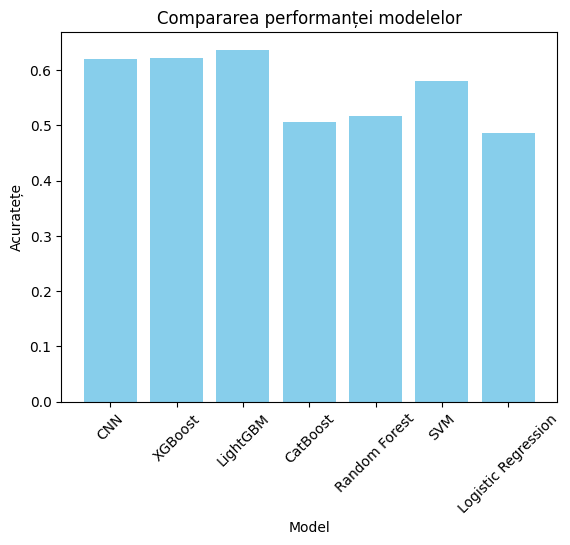

In [9]:
# ----- Compararea Performanței -----
print("\nComparăm acuratețea modelelor:")
for model, accuracy in accuracies.items():
    print(f"{model}: {accuracy:.4f}")

# Vizualizare Acuratețe
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.xlabel("Model")
plt.ylabel("Acuratețe")
plt.title("Compararea performanței modelelor")
plt.xticks(rotation=45)
plt.show()